<a href="https://colab.research.google.com/github/lizliu2015/Using-classification-to-predict-customer-catagory/blob/master/Predict_customer_churn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of content

1. Data ingestion and cleaning
2. EDA
3.LogisticRegression, SVM, RandomForest classification algorithms
4. Apply GridSearchCV to find the best hyperparameters
5. Model performance (confusion matrix, precision, recall, ROC AUC) 
6.Recommendation

*dataset: telco customer churn data

#1. Data Ingestion and cleaning

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

In [82]:
#loading kaggle API
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#!kaggle datasets list

Saving kaggle.json to kaggle (1).json


In [83]:
#load kaggle dataset
!kaggle datasets download -d blastchar/telco-customer-churn

telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [84]:
#unzip file
!unzip telco-customer-churn.zip -d /dev/shm 

Archive:  telco-customer-churn.zip
replace /dev/shm/WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
#read file
df = pd.read_csv('/dev/shm/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Data cleaning

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [87]:
#checking for missing value
print('<Contain NaNs?>')
print(df.isnull().any())
missing_ser_percentage = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
missing_ser_percentage = missing_ser_percentage[missing_ser_percentage!=0].round(2)
missing_ser_percentage.name = 'missing values %'
print('\n<NaN ratio>')
print(missing_ser_percentage)

<Contain NaNs?>
customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

<NaN ratio>
Series([], Name: missing values %, dtype: float64)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c57f23630>,
      dtype=object)

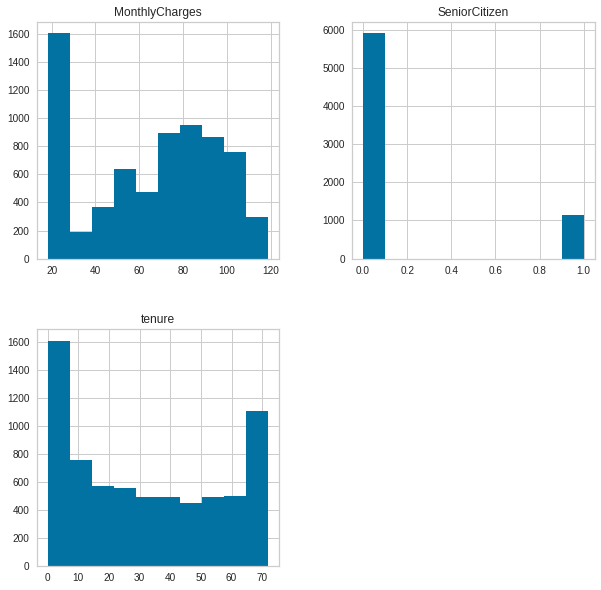

In [88]:
df.hist(figsize = (10,10))

In [0]:
#Data Manipulation

#Replacing spaces with null values in total charges column
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
df = df[df["TotalCharges"].notnull()]
df = df.reset_index()[df.columns]

#convert to float type
df["TotalCharges"] = df["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})
    
#replace values
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
df["tenure_group"] = df.apply(lambda df:tenure_lab(df),
                                      axis = 1)

#Separating churn and non churn customers
churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

#2. EDA

In [90]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_0-12
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_24-48
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_0-12
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_24-48
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_0-12


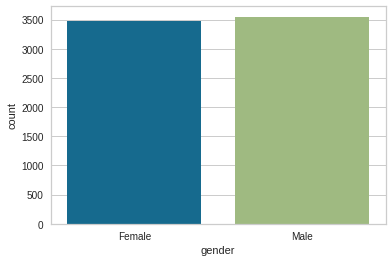

In [91]:
sns.countplot(df['gender'])

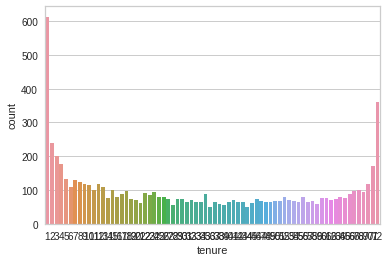

In [92]:
sns.countplot(df['tenure'])

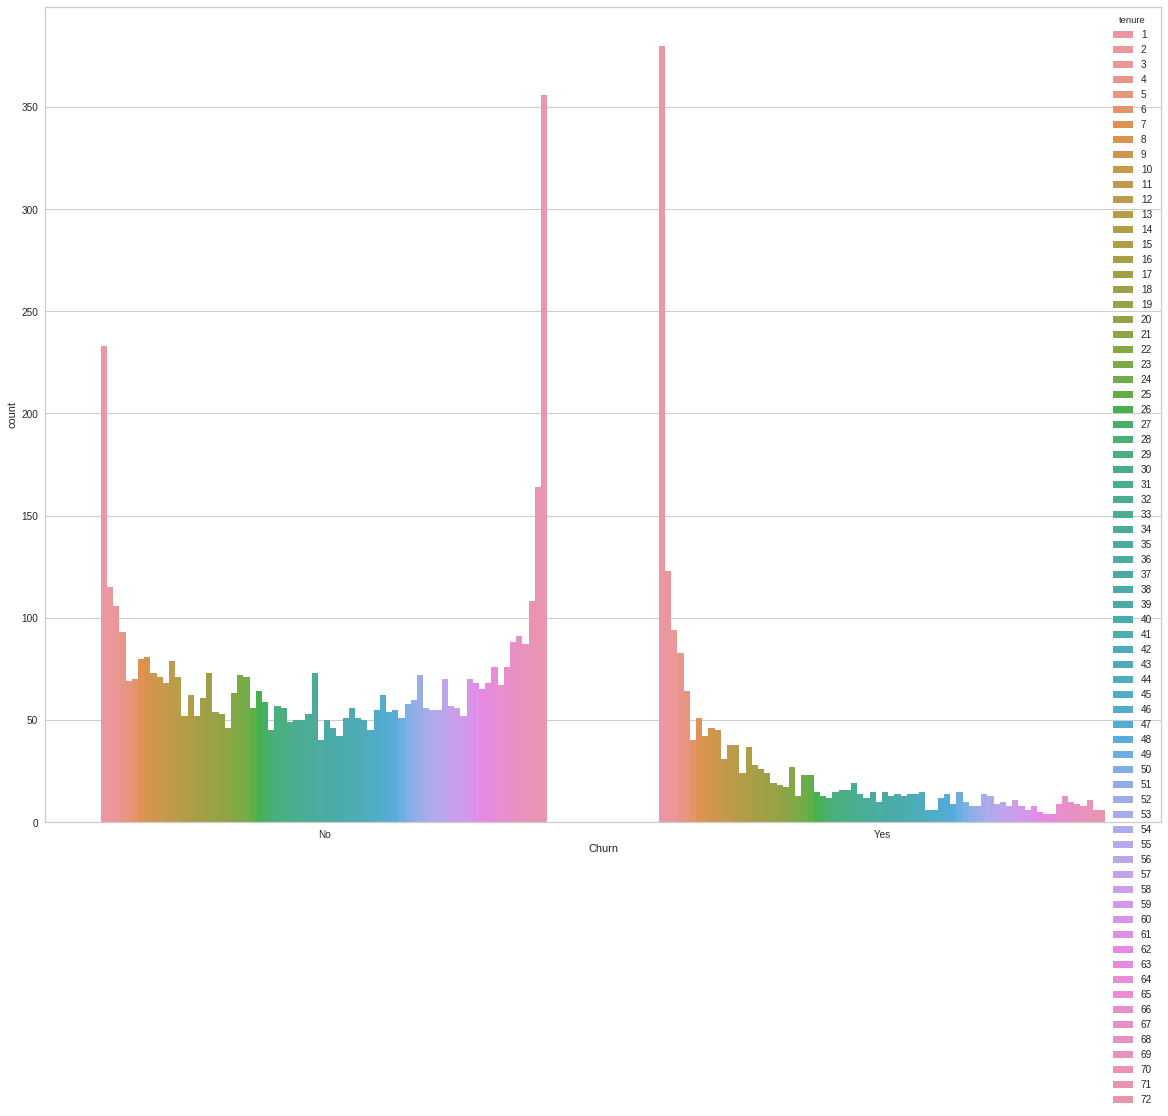

In [93]:
fig, axs = plt.subplots(figsize=(20, 15))
sns.countplot(df['Churn'],hue=df['tenure'])

# 3. Modeling

##Feature engineering

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]
#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_df_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

 Heatmap

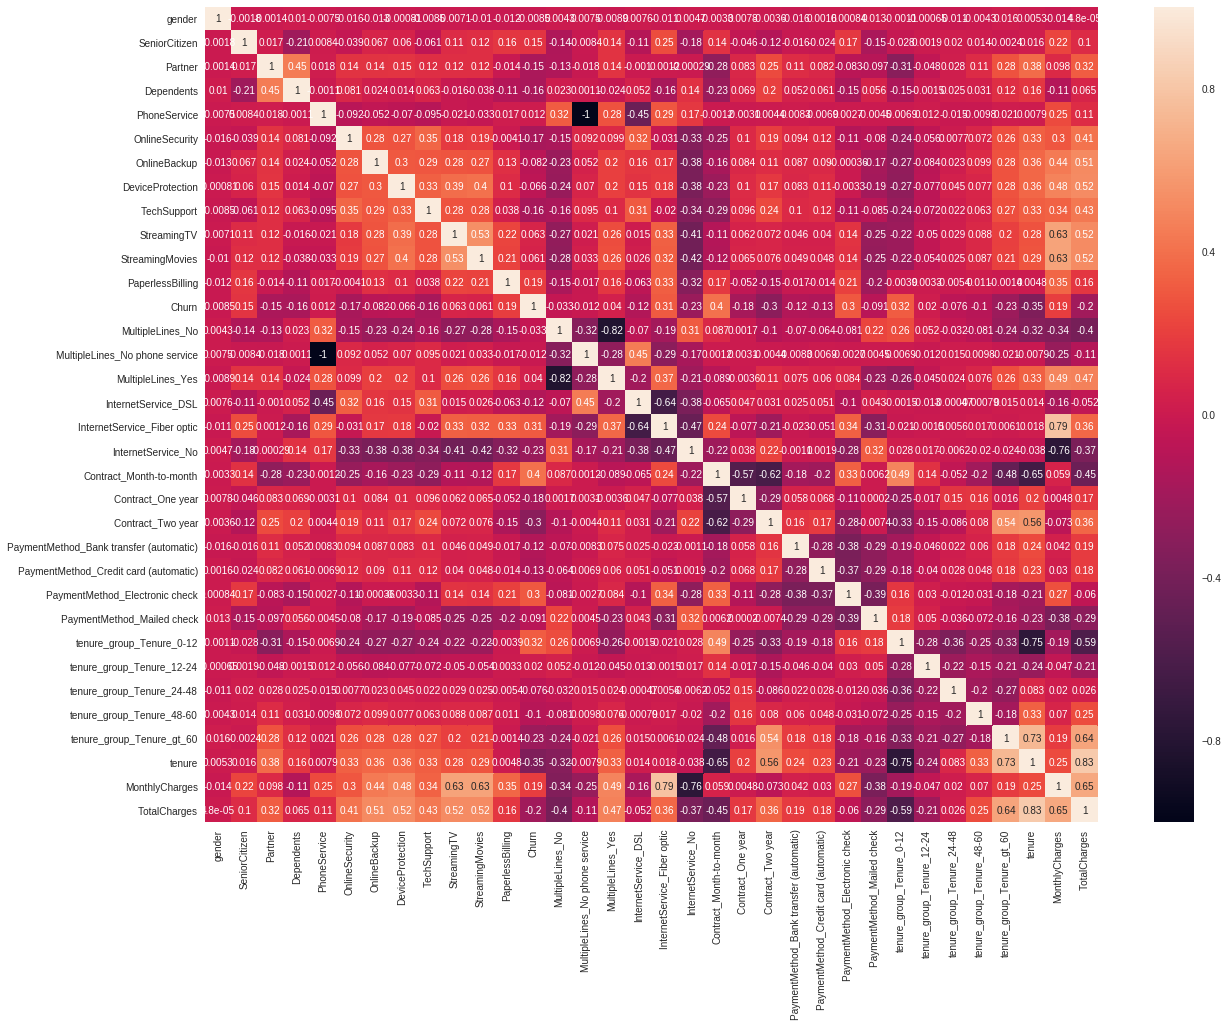

In [100]:
plt.figure(figsize=(20,15)) 
sns.heatmap(df.corr(), annot=True)

## Model preparation 

In [101]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#splitting train and test data 
train,test = train_test_split(df,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in df.columns if i not in Id_col + target_col]
X_train = train[cols]
y_train = train[target_col]
X_test  = test[cols]
y_test  = test[target_col]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5274, 33) (5274, 1)
(1758, 33) (1758, 1)


## Apply different models(LogisticRegression, RandomForest, SVC)

###Logistic Regression

In [102]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

model.score(X_test,y_test)

0.8026166097838453

###Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier()
rfr.fit(X_train,y_train)
print('The accuracy of the Random Forest is',rfr.score(X_test,y_test))

The accuracy of the Random Forest is 0.7781569965870307


###SVC

In [104]:
from sklearn import svm
svc=svm.SVC(gamma='auto_deprecated')
svc.fit(X_train,y_train)
prediction_svc=svc.predict(X_test)
print('The accuracy of the SVC is', svc.score(X_test,y_test))

The accuracy of the SVC is 0.7872582480091013


# 4. Using GridSearchCV to optimize the paramaters

In [105]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100,200, 300, 400],'max_depth' :[2,3,4,5]}
RF = RandomForestClassifier()

clf_RF = GridSearchCV(RF, parameters, cv=5)
clf_RF.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300, 400], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
clf_RF.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
RF = RandomForestClassifier(n_estimators=200, max_depth=5)
RF.fit(X_train,y_train)
prediction_RF=RF.predict(X_test)
print('The accuracy of the Random Forest Regression is',metrics.accuracy_score(prediction_RF,y_test))

The accuracy of the Random Forest Regression is 0.7815699658703071


In [111]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.1, 1, 10,100]}
SVC = svm.SVC(kernel='rbf')

clf_SVC = GridSearchCV(SVC, parameters, cv=5)
clf_SVC.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [112]:
clf_SVC.best_params_

{'C': 0.1}

In [113]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
SVC=svm.SVC(C = 0.1, kernel='rbf')
SVC.fit(X_train,y_train)
prediction_SVC=SVC.predict(X_test)
print('The accuracy of the SVC is',metrics.accuracy_score(prediction_SVC,y_test))

The accuracy of the SVC is 0.7878270762229806


#5. Model Performance

precision, recall, f1

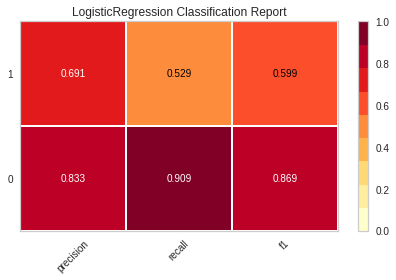

In [114]:
from yellowbrick.classifier import ClassificationReport
viz = ClassificationReport(lm)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

confusion matrix

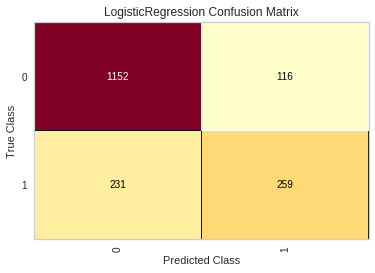

In [115]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(lm)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

* False Positive：
 
 - Customer will not churn, but we predict that they will churn
 
 
 * False Negatives: 
 
  - Customer will churn, but we predict they will not churn
  
 In our business case, we want to lower false negative, because this type of error leads to more unprepared loss on revenue

AUC - ROC

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 

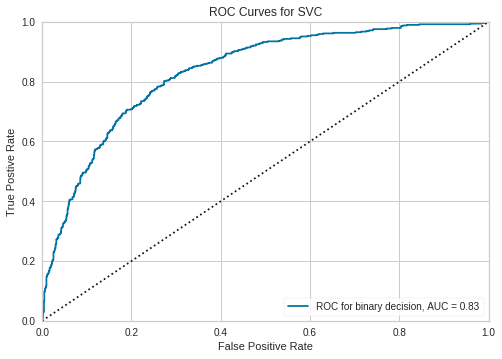

In [0]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(SVC, micro=False, macro=False, per_class=False)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)
visualizer.poof()             

#6. Recommendation

1. We found out that streaming movies and streaming TV's services have churn rate higher than other services, thus I suggest to improve the customer service for those two services in order to reduce the churn rate

2. Month to month customer churn higher than 1 year and 2 year contract customers, thus a better strategy if to try to engage the customer into longer contract after aquicision